<a href="https://colab.research.google.com/github/Maxlab/pytorch_learn/blob/master/CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch

import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

In [11]:
transform = transforms.Compose([
                                transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
                                ])

transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

training_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


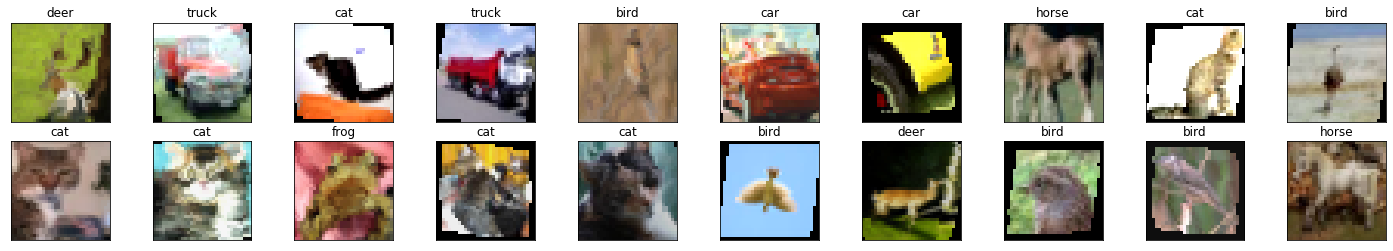

In [12]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)

      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x


In [14]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)


epochs = 15
loss_history = []
corrects_history = []
val_loss_history = []
val_corrects_history = []


for e in range(epochs):
  loss = .0
  corrects = .0
  val_loss = .0
  val_corrects = .0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    loss += loss.item()
    corrects += torch.sum(preds == labels.data)
 
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)

        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_loss += val_loss.item()
        val_corrects += torch.sum(val_preds == val_labels.data)
    
    count_tl = len(training_loader)
    epoch_loss = loss / count_tl
    epoch_acc  = corrects.float() / count_tl
    loss_history.append(epoch_loss)
    corrects_history.append(epoch_acc)

    val_epoch_loss = val_loss / len(validation_loader)
    val_epoch_acc  = val_corrects.float() / len(validation_loader)
    val_loss_history.append(val_epoch_loss)
    val_corrects_history.append(val_epoch_acc)


    print("Epoch: {}  Count_TrainLoader: {}  TrainLoss: {:.4f}  ValLoss: {:.4f}".format(e+1, count_tl, epoch_acc, val_epoch_acc))

Epoch: 1  Count_TrainLoader: 500  TrainLoss: 37.8560  ValLoss: 48.2400
Epoch: 2  Count_TrainLoader: 500  TrainLoss: 50.6500  ValLoss: 56.0500
Epoch: 3  Count_TrainLoader: 500  TrainLoss: 55.8600  ValLoss: 59.5700
Epoch: 4  Count_TrainLoader: 500  TrainLoss: 58.8740  ValLoss: 62.4500
Epoch: 5  Count_TrainLoader: 500  TrainLoss: 61.1400  ValLoss: 64.2000
Epoch: 6  Count_TrainLoader: 500  TrainLoss: 62.7320  ValLoss: 67.1500
Epoch: 7  Count_TrainLoader: 500  TrainLoss: 64.6260  ValLoss: 67.9200
Epoch: 8  Count_TrainLoader: 500  TrainLoss: 65.7520  ValLoss: 68.4900
Epoch: 9  Count_TrainLoader: 500  TrainLoss: 66.6640  ValLoss: 68.5400
Epoch: 10  Count_TrainLoader: 500  TrainLoss: 67.5280  ValLoss: 70.7300
Epoch: 11  Count_TrainLoader: 500  TrainLoss: 67.9260  ValLoss: 70.5100
Epoch: 12  Count_TrainLoader: 500  TrainLoss: 68.9300  ValLoss: 71.8500
Epoch: 13  Count_TrainLoader: 500  TrainLoss: 69.4280  ValLoss: 72.3300
Epoch: 14  Count_TrainLoader: 500  TrainLoss: 69.5120  ValLoss: 71.2200
E

In [0]:
import PIL.ImageOps
import requests
from PIL import Image

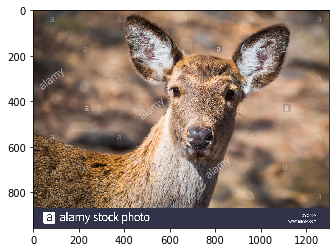

In [24]:
url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

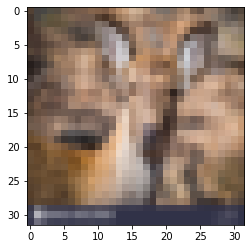

In [25]:
img = transform(img) 
plt.imshow(im_convert(img))

In [27]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

deer


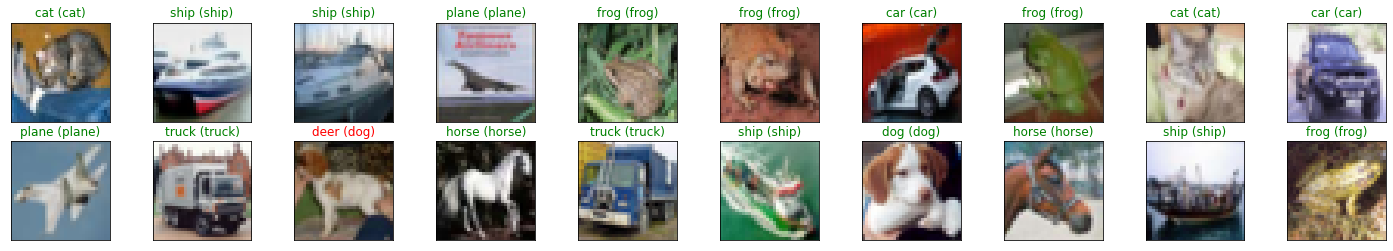

In [28]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))